# Assignment 10: A* pathfinding
A* pathfinding is a commonly used algorithm for find the shortest traversable distance in applications like route finding in maps to AI pathfinding in video games. It is similar to Dijkstra's algorithm, but rather than traversing all nodes, it uses a cost calculation that allows the untraversed nodes to be sorted in a heap structure. For example, let's say we have a binary array of size (5, 5), where each value is a map tile:
```
[0  0  0  0  0
 0  0  1  0* 0
 0  0  1  0  0
 0  0  0  1  0
 0  0  0  0  0]
```
Your goal is to traverse the map from the bottom left point to the tile denoted by the asterisk. Any space on the map occupied by 0 is considered walkable, whereas 1 represents an impassable barrier. In this exercise we will create an algorithm that efficiently calculates the shortest walkable path to the goal.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# A function for plotting a map
def plot_grid(array, start, goal):
    fig, axs = plt.subplots()
    axs.imshow(array, cmap="binary")
    
    # Grid on minor ticks
    axs.set_xticks(np.arange(-0.5, array.shape[1]), minor=True)
    axs.set_yticks(np.arange(-0.5, array.shape[0]), minor=True)
    axs.grid(visible=True, which="minor")
    
    # Show start/goal
    axs.scatter(start[1], start[0], c="c")
    axs.scatter(goal[1], goal[0], c="r")
    axs.set(xticks=[], yticks=[])
    
    plt.show()

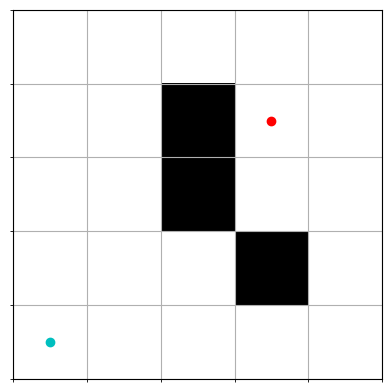

In [4]:
# Plot the example above
array = np.array(
    [[0,  0,  0,  0,  0],
     [0,  0,  1,  0,  0],
     [0,  0,  1,  0,  0],
     [0,  0,  0,  1,  0],
     [0,  0,  0,  0,  0]]
)
start = (4, 0)
goal = (1, 3)
plot_grid(array, start, goal)

## Define nodes
Create a class `Node` for each tile in the map. These will contain:
1. A value `g`, the distance from the start node to this node
2. A value `h`, the heuristic, or estimated distance to the end node
3. A value `f`, the total cost of the node as defined by `f + g`
4. The map coordinate `coord`
5. A boolean designation `walkable`
6. A `parent` pointer

In [72]:
# Define Node with (x, y) tuple for `coord`
class Node:
    def __init__(self, coord, walkable):
        self.coord = coord  # Coordinate of the node (x, y)
        self.walkable = walkable  # Boolean indicating if the node is walkable
        self.g = float('inf')  # Distance from start node, initialized to infinity
        self.h = 0  # Heuristic distance to the end node
        self.f = float('inf')  # Total cost, initialized to infinity
        self.parent = None  # Pointer to the parent node

    def __lt__(self, other):
        return self.f < other.f  # Comparison method for priority queue



## The algorithm
The main function will need to accept three arguments: the map array, the starting position, and the end position. Generally, you will have two lists of nodes: one for nearby candidate nodes that have yet to be traversed (`open_list`), and one of nodes you've already visited (`closed_list`). Here are the steps:
1. Add the starting node to the open list.
2. Repeat the following:<br />
    1. Look for the lowest F cost square on the open list. We refer to this as the current square.<br />
    2. Switch it to the closed list.<br />
    3. For each of the 8 squares adjacent to this current square:<br />
        1. If it is not walkable or if it is on the closed list, **ignore it and move to the next neighbor**.<br /> Otherwise do the following:<br />
        2. If it isn’t on the open list, add it to the open list.<br />
        3. Make the current square the parent of this square.<br />
        4. Record the F, G, and H costs of the square.<br />
        5. If it is on the open list already, check to see if this path to that square is better, using G cost as the measure. A lower G cost means that this is a better path. If so, change the parent of the square to the current square, and recalculate the G and F scores of the square. If you are keeping your open list sorted by F score, you may need to resort the list to account for the change.<br />
    4. Stop when you:<br />
        1. Add the target square to the closed list, in which case the path has been found, or<br />
        2. Fail to find the target square, and the open list is empty. In this case, there is no path.<br />
3. Save the path. Working backwards from the target square, go from each square to its parent square until you reach the starting square. That is your path.
4. **Return the path (`None` if not found) and the listed of traversed coordinates.** These arguments will be passed to the plotting function below.

In this case, the `open_list` will be a minimum heap. Create a class `Heap` the has:
1. `heap`: a list of nodes
2. A function `append` for adding nodes to the heap.
3. A function `sift_up` for sifting a node to the top of the heap
4. A function `heapify` for sorting the heap such that the minimum is on top.
5. A `pop` function for removing and returning the node with the minimum cost

In [139]:
# Define Heap
import heapq

class Heap:
    def __init__(self):
        self.heap = []

    def append(self, node):
        heapq.heappush(self.heap, node)

    def pop(self):
        return heapq.heappop(self.heap)

    def __len__(self):
        return len(self.heap)


Now implement a main function that performs the tasks of the algorithm

In [129]:
def a_star_search(map_array, start, goal):
    # Initializing the Start and End Nodes
    start_node = Node(start, True)
    goal_node = Node(goal, True)
    # Create the Open List that explores all of the possible cell that the path can take
    open_list = Heap()
    # The closed list contains the unique nodes that have already been explored
    closed_list = set()

    # Appending the first node to the Open List
    start_node.g = 0
    start_node.h = heuristic(start_node.coord, goal_node.coord)
    start_node.f = start_node.g + start_node.h
    open_list.append(start_node)

    while len(open_list) > 0:
        # current_node takes the value of the lowest f values from the open_list
        current_node = open_list.pop()
        # Adds the coordinates of the lowest f value to the closed list, marking it as explored
        closed_list.add(current_node.coord)

        # Checks if the current node is the goal node, meaning it found the end of the path
        if current_node.coord == goal_node.coord:
            # returns the reconstucted path
            return reconstruct_path(current_node), closed_list

        # Gets all the walkable neighboring nodes
        neighbors = get_neighbors(current_node, map_array)
        # Iterates through each neighbor and skips if the neighbor has already been explored
        for neighbor in neighbors:
            if neighbor.coord in closed_list or not neighbor.walkable:
                continue

            # Calculates the cost of g
            tentative_g = current_node.g + 1  # Assuming uniform cost for simplicity

            # If the new path to the neighbor is shorter, update the costs
            if tentative_g < neighbor.g:
                neighbor.parent = current_node
                neighbor.g = tentative_g
                neighbor.h = heuristic(neighbor.coord, goal_node.coord)
                neighbor.f = neighbor.g + neighbor.h
                # Appends the neighbor in the open list if not in it
                if neighbor not in open_list.heap:
                    open_list.append(neighbor)
    
    return None, closed_list

def heuristic(coord1, coord2):
    # Using Manhattan distance as heuristic
    return abs(coord1[0] - coord2[0]) + abs(coord1[1] - coord2[1])

def get_neighbors(node, map_array):
    neighbors = []
    # the applicable path directions that each coord can go to reach a neighbor
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    # Iterates through each direction and calculates the coordinates of neighbor
    for direction in directions:
        neighbor_coord = (node.coord[0] + direction[0], node.coord[1] + direction[1])
        # Checks if the neighbor coordinates are in the map array
        if 0 <= neighbor_coord[0] < len(map_array) and 0 <= neighbor_coord[1] < len(map_array[0]):
            # determines if they are walkable
            walkable = map_array[neighbor_coord[0]][neighbor_coord[1]] == 0
            # appends the node of the neighbor to the list
            neighbors.append(Node(neighbor_coord, walkable))
    # returns the list of applicable neighbors
    return neighbors

def reconstruct_path(node):
    path = []
    # if the node exists, it appends the path backwards to the path list
    while node is not None:
        path.append(node.coord)
        node = node.parent
    return path[::-1]


In [125]:
x = a_star_search(array, start, goal)
x[0].f

inf

## Plot some scenarios
Below are functions for generating random, scalable maps and plotting the path and visited nodes.

In [45]:
def plot_path(array, path, visited, start, goal):
    """
    Function for plotting the Astar outcome.
    
    Parameters
    array: binary array where 0 is walkable
    path: the output path from astar
    visited: list of visited nodes
    start: starting coord
    goal: ending coord
    """
    fig, axs = plt.subplots(1, 2)
    for i, coord_list in enumerate([path, visited]):
        axs[i].imshow(array, cmap="binary")
        
        if coord_list:
            y = [coord[0] for coord in coord_list]
            x = [coord[1] for coord in coord_list]
            if i == 0:
                axs[i].scatter(x, y)
            else:
                axs[i].scatter(x, y, c="y")
            
        # Grid on minor ticks
        axs[i].set_xticks(np.arange(-0.5, array.shape[1]), minor=True)
        axs[i].set_yticks(np.arange(-0.5, array.shape[0]), minor=True)
        axs[i].grid(visible=True, which="minor")

        # Show start/goal
        axs[i].scatter(start[1], start[0], c="c")
        axs[i].scatter(goal[1], goal[0], c="r")
        axs[i].set(xticks=[], yticks=[])
    
    plt.show()

In [15]:
# Plot your solution path and visited nodes from the example map at the beginning


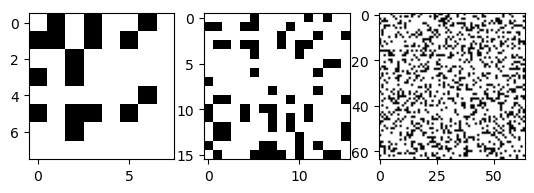

In [16]:
# Generate some random maps to walk
def random_map(rows, cols, density=0.3):
    """ A function for generating random maps for walking from top left (0,0) to bottom right (len - 1, len - 1) corners """
    
    # Generate a random traversable array with obstacles
    array = np.zeros((rows, cols), dtype=int)
    num_obstacles = int(rows * cols * density)  # Adjust obstacle density as needed

    # Randomly place obstacles
    for _ in range(num_obstacles):
        x = np.random.randint(0, rows)
        y = np.random.randint(0, cols)
        array[x, y] = 1

    # Make sure the start and end corners are walkable
    array[0, 0] = 0
    array[rows - 1, cols - 1] = 0

    return array

# Plot a few examples
fig, ax = plt.subplots(1, 3)
ax[0].imshow(random_map(8, 8), cmap="binary")
ax[1].imshow(random_map(16, 16), cmap="binary")
ax[2].imshow(random_map(64, 64), cmap="binary")
plt.show()

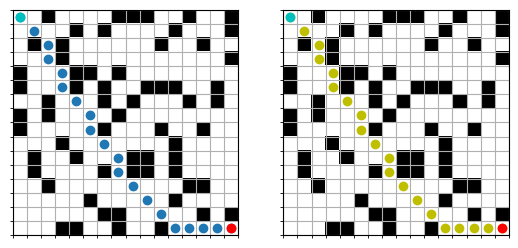

In [137]:
# Try substituting different array dimensions and densities
# (warning: very large dimension might take a while without a heap)
array = random_map(16, 16, density=0.3)

# Do not change these. We made sure the start and goal are open in the map generation
start = (0, 0)
goal = (array.shape[0] - 1, array.shape[1] - 1)

# Call your pathfinding below on the random map and then plot it with `plot_path()` from earlier
path, visited = a_star_search(array, start, goal)
plot_path(array, path, visited, start, goal)
